## Binary Classification Problem Statements
#### Algorithms Used: 
1. Classifying arrest made or not, based on factors such as crime type, time, area, and victim demographics?”
2. “Can we distinguish between violent and non-violent crimes using structured data such as weapon type, premise, and crime category?”
3. “Can we predict whether a crime will involve a weapon or not, given the premise, area, and time of occurrence?”

## Importing Libraries and Dataset

In [106]:
!pip install xgboost

   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/56.8 MB ? eta -:--:--
   -----------------

In [118]:
!pip install seaborn

In [119]:
#Importing the libraries
import datetime
import numpy as np
import pandas as pd
import xgboost as xgb 
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.metrics import accuracy_score ,precision_score ,recall_score,f1_score,roc_curve,auc,confusion_matrix, classification_report

In [2]:
data = pd.read_csv("LA_Crime_dataset.csv")

## Classifying arrest made based on crime type, time, area and victim demographics
- Algorithms used: Log Reg, SVM, L1 and L2 (Hyperparameter Tuning), RanfomForestRegressor
- Target (y): From Status Description: Arrest Made = 1, No Arrest = 0.
- Features (X): Hour, Month, Area ID, Crime Description, Victim Age, Victim Sex, Victim Descent, Weapon Used (Yes/No).

### Data Preprocessing and EDA

#### Creating and Modifying Dataset/Columns

In [3]:
#Creating dataset
bin_class_1 = data[["AREA","Crm Cd","Vict Age","Vict Sex","Vict Descent","Weapon Used Cd"]]

In [4]:
#Creating Hour and Month column and droppong TIME OCC amd DATE OCC
bin_class_1['Hour'] = pd.to_datetime(data['TIME OCC'].astype(str).str.zfill(4),format='%H%M').dt.hour
bin_class_1['Month'] = pd.to_datetime(data['DATE OCC'].astype(str)).dt.month

C:\Users\abhes\AppData\Local\Temp\ipykernel_2468\828689147.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin_class_1['Hour'] = pd.to_datetime(data['TIME OCC'].astype(str).str.zfill(4),format='%H%M').dt.hour
C:\Users\abhes\AppData\Local\Temp\ipykernel_2468\828689147.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  bin_class_1['Month'] = pd.to_datetime(data['DATE OCC'].astype(str)).dt.month
C:\Users\abhes\AppData\Local\Temp\ipykernel_2468\828689147.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [5]:
#Creating target variable column
status_map = {
    'Adult Arrest': 1,
    'Juv Arrest': 1,
    'Invest Cont': 0,
    'Adult Other': 0,
    'Juv Other': 0,
    'UNK': 0
}
bin_class_1['Arrest_Made'] = data['Status Desc'].map(status_map)

C:\Users\abhes\AppData\Local\Temp\ipykernel_2468\1192855102.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin_class_1['Arrest_Made'] = data['Status Desc'].map(status_map)


#### Dataset Information and Null Value handling

In [6]:
bin_class_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004991 entries, 0 to 1004990
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   AREA            1004991 non-null  int64  
 1   Crm Cd          1004991 non-null  int64  
 2   Vict Age        1004991 non-null  int64  
 3   Vict Sex        860347 non-null   object 
 4   Vict Descent    860335 non-null   object 
 5   Weapon Used Cd  327247 non-null   float64
 6   Hour            1004991 non-null  int32  
 7   Month           1004991 non-null  int32  
 8   Arrest_Made     1004991 non-null  int64  
dtypes: float64(1), int32(2), int64(4), object(2)
memory usage: 61.3+ MB


In [7]:
bin_class_1.describe()

,AREA,Crm Cd,Vict Age,Weapon Used Cd,Hour,Month,Arrest_Made
count,1.004991e+06,1.004991e+06,1.004991e+06,327247.000000,1.004991e+06,1.004991e+06,1.004991e+06
mean,1.069174e+01,5.001568e+02,2.891706e+01,363.955300,1.322082e+01,6.370997e+00,8.999185e-02
std,6.110255e+00,2.052731e+02,2.199272e+01,123.734528,6.510223e+00,3.463282e+00,2.861702e-01
min,1.000000e+00,1.100000e+02,-4.000000e+00,101.000000,0.000000e+00,1.000000e+00,0.000000e+00
25%,5.000000e+00,3.310000e+02,0.000000e+00,311.000000,9.000000e+00,3.000000e+00,0.000000e+00
50%,1.100000e+01,4.420000e+02,3.000000e+01,400.000000,1.400000e+01,6.000000e+00,0.000000e+00
75%,1.600000e+01,6.260000e+02,4.400000e+01,400.000000,1.900000e+01,9.000000e+00,0.000000e+00
max,2.100000e+01,9.560000e+02,1.200000e+02,516.000000,2.300000e+01,1.200000e+01,1.000000e+00


In [8]:
#Using for loop to check number of unique values in columns
check_unique = bin_class_1.iloc[:,:8]
for col in check_unique:
    unq = bin_class_1[col].nunique()
    print(f"{col} : {unq}")

AREA : 21
Crm Cd : 140
Vict Age : 104
Vict Sex : 5
Vict Descent : 20
Weapon Used Cd : 79
Hour : 24
Month : 12


In [9]:
#Checking null values
bin_class_1.isna().sum()
# filling NaN values 
bin_class_1[["Vict Sex","Vict Descent","Weapon Used Cd"]] = bin_class_1[["Vict Sex","Vict Descent","Weapon Used Cd"]].fillna("Unknown")

C:\Users\abhes\AppData\Local\Temp\ipykernel_2468\2598228584.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin_class_1[["Vict Sex","Vict Descent","Weapon Used Cd"]] = bin_class_1[["Vict Sex","Vict Descent","Weapon Used Cd"]].fillna("Unknown")


In [10]:
bin_class_1.nsmallest(140,"Vict Age")

,AREA,Crm Cd,Vict Age,Vict Sex,Vict Descent,Weapon Used Cd,Hour,Month,Arrest_Made
3119,1,662,-4,X,X,Unknown,12,1,1
22468,1,622,-4,X,X,511.0,12,1,0
67712,1,662,-4,M,A,Unknown,12,1,0
3252,21,442,-3,M,W,Unknown,11,12,1
11920,6,354,-3,X,X,Unknown,13,8,0
...,...,...,...,...,...,...,...,...,...
819153,17,762,-1,X,X,Unknown,2,12,1
829610,10,668,-1,M,O,Unknown,8,1,0
12,21,510,0,Unknown,Unknown,Unknown,15,9,1
13,17,310,0,X,X,Unknown,5,7,0


#### Encoding Mutli-Category columns to Binary columns

In [18]:
multi_col = ["AREA", "Crm Cd", "Vict Sex","Vict Descent", "Weapon Used Cd"]
bin_class_1_encoded = pd.get_dummies(bin_class_1, columns = multi_col, drop_first = True)
bin_class_1_encoded.columns

Index(['Vict Age', 'Hour', 'Month', 'Arrest_Made', 'AREA_2', 'AREA_3',
       'AREA_4', 'AREA_5', 'AREA_6', 'AREA_7',
       ...
       'Weapon Used Cd_508.0', 'Weapon Used Cd_509.0', 'Weapon Used Cd_510.0',
       'Weapon Used Cd_511.0', 'Weapon Used Cd_512.0', 'Weapon Used Cd_513.0',
       'Weapon Used Cd_514.0', 'Weapon Used Cd_515.0', 'Weapon Used Cd_516.0',
       'Weapon Used Cd_Unknown'],
      dtype='object', length=267)

In [76]:
st = StandardScaler()
st

,copy,True
,with_mean,True
,with_std,True


In [85]:
#Splitting X and y
X = bin_class_1_encoded.drop(columns = "Arrest_Made")
y = bin_class_1_encoded["Arrest_Made"]
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size = 0.2 , random_state =42)
xtrain_scaled = st.fit_transform(xtrain)
xtest_scaled = st.fit_transform(xtest)
xtrain_scaled.shape,xtest_scaled.shape,ytest.shape,ytrain.shape

((803992, 266), (200999, 266), (200999,), (803992,))

In [86]:
arrest_made = bin_class_1_encoded[bin_class_1_encoded.Arrest_Made == 1]
no_arrest_made = bin_class_1_encoded[bin_class_1_encoded.Arrest_Made == 0]
arrest_made_sampling = resample(arrest_made,replace=True,n_samples=80,random_state=42)
bin_class_concat = pd.concat([arrest_made_sampling,no_arrest_made])
X_train_balanced = bin_class_concat.drop('Arrest_Made', axis=1)
y_train_balanced = bin_class_concat['Arrest_Made']

### Logistics Regression: Model Creation and Evaluation 

In [90]:
#Fitting model
lr_1 = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_1.fit(xtrain_scaled,ytrain)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [91]:
#Prediction
predict = lr_1.predict(xtest_scaled)

In [92]:
print(confusion_matrix(ytest,predict))

[[125856  57117]
 [  4471  13555]]


In [93]:
print(classification_report(ytest,predict))

              precision    recall  f1-score   support

           0       0.97      0.69      0.80    182973
           1       0.19      0.75      0.31     18026

    accuracy                           0.69    200999
   macro avg       0.58      0.72      0.55    200999
weighted avg       0.90      0.69      0.76    200999



### Random Forest

In [87]:
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train_balanced,y_train_balanced)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [88]:
predict = rf.predict(xtest)

In [89]:
print(classification_report(ytest,predict))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95    182973
           1       0.53      0.00      0.00     18026

    accuracy                           0.91    200999
   macro avg       0.72      0.50      0.48    200999
weighted avg       0.88      0.91      0.87    200999



### Gradient Boosting Classifier

In [100]:
gb = GradientBoostingClassifier(n_estimators = 100, random_state =4, n_jobs = -1)
gb.fit(X_train_balanced, y_train_balanced)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [102]:
predict = gb.predict(xtest)

In [103]:
confusion_matrix(ytest,predict)

array([[182951,     22],
       [ 18019,      7]])

In [105]:
print(classification_report(ytest,predict))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95    182973
           1       0.24      0.00      0.00     18026

    accuracy                           0.91    200999
   macro avg       0.58      0.50      0.48    200999
weighted avg       0.85      0.91      0.87    200999



In [110]:
counter = Counter(ytrain)
scale_pos_weight_value = counter[0] / counter[1]

In [111]:
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',scale_pos_weight=scale_pos_weight_value,random_state=42,n_jobs=-1)

In [112]:
xgb_model.fit(xtrain_scaled, ytrain)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [113]:
predictions = xgb_model.predict(xtest_scaled)

In [114]:
print(confusion_matrix(ytest, predictions))

[[123383  59590]
 [  5412  12614]]


In [115]:
print(classification_report(ytest, predictions))

              precision    recall  f1-score   support

           0       0.96      0.67      0.79    182973
           1       0.17      0.70      0.28     18026

    accuracy                           0.68    200999
   macro avg       0.57      0.69      0.54    200999
weighted avg       0.89      0.68      0.75    200999



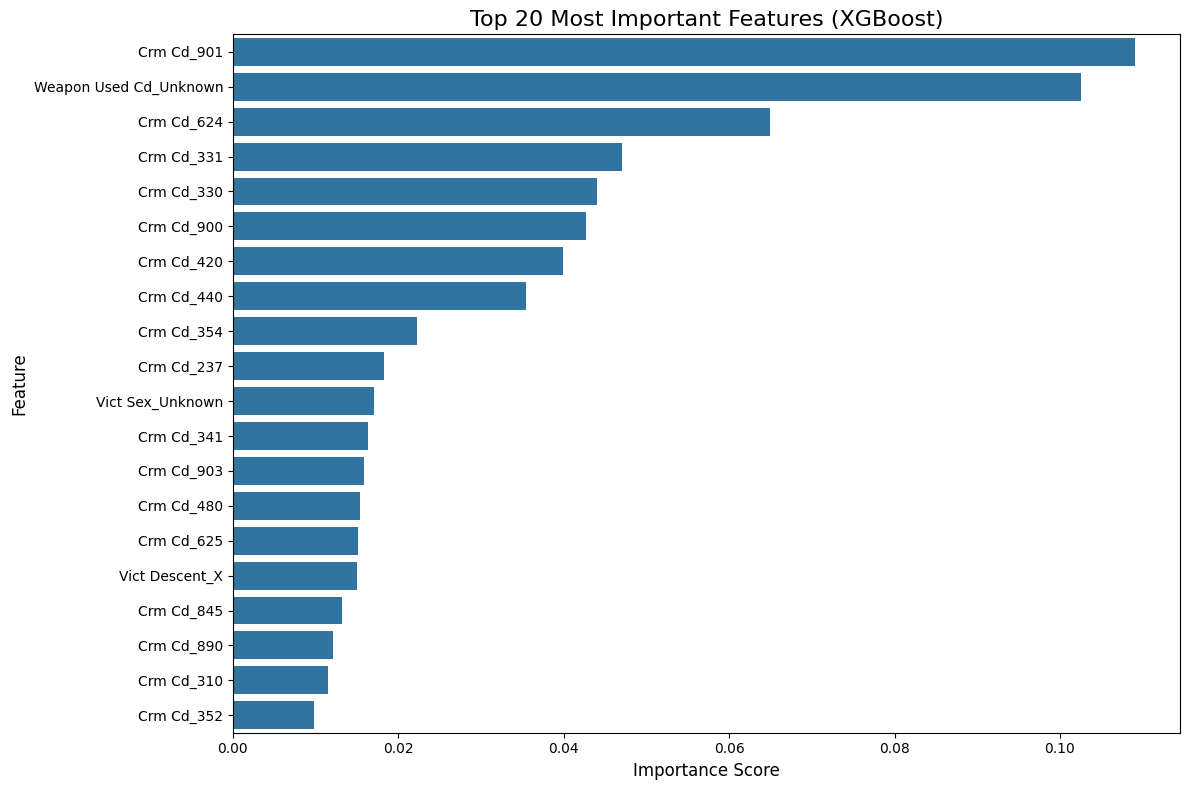

In [120]:
importances = xgb_model.feature_importances_
feature_names = X.columns

# 2. Create a DataFrame for easy sorting and plotting
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# 3. Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# 4. Create a bar plot of the top 20 features
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))
plt.title('Top 20 Most Important Features (XGBoost)', fontsize=16)
plt.xlabel('Importance Score', fontsize= 12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()